The following code is adapted from: https://www.kaggle.com/androbomb/simple-nn-with-python-multi-layer-perceptron/notebook

# Basics of Artificial Neural Networks <a></a>

Artificial neural networks (ANN or NN) are computing systems that are inspired by, but not identical to, biological neural networks that constitute animal brains. Such systems learn to perform tasks by considering examples, generally without being programmed with task-specific rules.

A NN is based on a collection of connected units or nodes called artificial neurons, which loosely model the neurons in a biological brain. The basic example is the perceptron [1]. Each connection, like the synapses in a biological brain, can transmit a signal to other neurons. An artificial neuron that receives a signal then processes it and can signal neurons connected to it [2].

In ANN implementations, the "signal" at a connection is a real number, and the output of each neuron is computed by some non-linear function of the sum of its inputs. The connections are called edges. Neurons and edges typically have a weight that adjusts as learning proceeds. The weight increases or decreases the strength of the signal at a connection. Neurons may have a threshold such that a signal is sent only if the aggregate signal crosses that threshold. Typically, neurons are aggregated into layers. Different layers may perform different transformations on their inputs. Signals travel from the first layer (the input layer), to the last layer (the output layer), possibly after traversing the layers multiple times. [b],

![ANN](https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg)

### Single-layer and Multi-layer perceptrons
A single layer perceptron (SLP) is a feed-forward network based on a threshold transfer function. SLP is the simplest type of artificial neural networks and can only classify linearly separable cases with a binary target (1, 0). [c], [d]

Because SLP is a linear classifier and if the cases are not linearly separable the learning process will never reach a point where all the cases are classified properly. The most famous example of the inability of perceptron to solve problems with linearly non-separable cases is the XOR problem.

A multi-layer perceptron (MLP) has the same structure of a single layer perceptron with one or more hidden layers. The backpropagation algorithm consists of two phases: the forward phase where the activations are propagated from the input to the output layer, and the backward phase, where the error between the observed actual and the requested nominal value in the output layer is propagated backwards in order to modify the weights and bias values.

-------
[1] https://en.wikipedia.org/wiki/Perceptron

[2] https://en.wikipedia.org/wiki/Artificial_neural_network

[3] https://www.saedsayad.com/artificial_neural_network_bkp.htm

[4] https://iamtrask.github.io/2015/07/12/basic-python-network/

[5] https://www.freecodecamp.org/news/building-a-neural-network-from-scratch/

[6] https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6?

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Required to display matplotlib plots in notebooks
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import itertools 

In [2]:
# Change directory to your own working directory accordingly
currentDir = os.getcwd()

pictureDir = os.path.join(currentDir, "MLP")
pictureDir = os.path.join(pictureDir, "NN")
if os.path.exists(pictureDir) == False:
    os.mkdir(pictureDir)

In [3]:
df = pd.read_csv("data.csv")

# Removal of irrelevant columns
df.drop('IDshort', axis=1, inplace=True)
df.drop('SERNO', axis=1, inplace=True)

# Encode categorical values
gender = df['Gender'].astype('category')
histocode = df['HistoCode'].astype('category')
df['Gender'] = gender.cat.codes
df['HistoCode'] = histocode.cat.codes

# replacing empty data and 'ND' with np.nan and then filling it with the median
for colName in df:
    df[colName].replace('', np.nan, inplace=True)
    df[colName].replace('ND', np.nan, inplace=True)
    df[colName] = df.fillna(value=df[colName].median(), inplace=True)

df.head(4)

,Age,Weightkg,Heightcm,Pulse,WaistCircumferencecm,Gender,SBP,DBP,Hips_Circumference__cm,Hypertension__Yes_1_No_0,...,HistoMet1_ConcµM,HistoHis1_ConcµM,HistoPhe1_ConcµM,HistoCit1_ConcµM,HistoTyr1_ConcµM,HistoAsp1_ConcµM,HistoGlu1_ConcµM,HistoTrp1_ConcµM,Cardiac_Category (0=good; 1=poor),Cardiac_Category EE (0=good; 1=poor)
0,58.9,157.5,74.5,80.5,0.5,145.0,74.0,93.0,1.0,0.0,...,94.971,96.797,40.534,79.3955,49.6495,166.9485,65.5515,1.0,0.0,None
1,58.9,157.5,74.5,80.5,0.5,145.0,74.0,93.0,1.0,0.0,...,94.971,96.797,40.534,79.3955,49.6495,166.9485,65.5515,1.0,0.0,None
2,58.9,157.5,74.5,80.5,0.5,145.0,74.0,93.0,1.0,0.0,...,94.971,96.797,40.534,79.3955,49.6495,166.9485,65.5515,1.0,0.0,None
3,58.9,157.5,74.5,80.5,0.5,145.0,74.0,93.0,1.0,0.0,...,94.971,96.797,40.534,79.3955,49.6495,166.9485,65.5515,1.0,0.0,None


# The Data

In our case, we have 8 different sets of features, colour-coded and categorised into 8 categories:
1. Clinical Parameters
2. Exercise
3. Echo Measurements
4. CMR Measurements
5. Blood Biomarkers
6. Physical Function Parameters
7. Current Metabolomics
8. Historical Metabolomics

In [4]:
# Splitting features into different dataframes based on categories
X_clinical_params = df.loc[:, 'Age':'AlcoholNever0Current1Past']
X_exercise = df.loc[:, 'PhysicalactivityfrequencyIna':'VO2Max']
X_echo_measurements = df.loc[:, 'BSA__m2':'E_Eprime_ratio']
X_cmr_measurements = df.loc[:, 'LV_Mass_on_mri__g':'LVSVImlm2']
X_blood_biomarkers = df.loc[:, 'MCP1pgmL':'HbA1c']
X_physical_func_params = df.loc[:, 'Gripmax': 'ALM']
X_curr_metabolomics = df.loc[:, 'TC':'Trp1']
X_hist_metabolomics = df.loc[:, 'HistoC2':'HistoTrp1_ConcµM']

features = [X_clinical_params, X_exercise, X_echo_measurements, X_cmr_measurements, X_blood_biomarkers, X_physical_func_params, X_curr_metabolomics, X_hist_metabolomics]

# Cardiac outcomes
y1 = df['Cardiac_Category (0=good; 1=poor)']
y2 = df['Cardiac_Category EE (0=good; 1=poor)']

labels = [y1, y2]

# Perceptron

The perceptron is a basic function that mimics the human neuron. It receives $n$ inputs, associated to the dendrites inputs to the neuron. Each dendrite, due to *lernging*, is weighted by a number that signals its input relevance for the neuron [1]. 

![Neuron](https://upload.wikimedia.org/wikipedia/commons/a/a9/Complete_neuron_cell_diagram_en.svg)

The signal is thus elaborated and passed through the *axon* to others neurons [2]; actually, the neurons *fires* the signal only if the elaborated inputs have surpassed a certain threshold; this is a spiking neuron [3].

The perceptron wants to mimic it. Receinving a vector (i.e. array) $x_i$ of signals, where $i$ stands for the $i$-th dendrites, it weights each of them by a vector of weights $w_i$. It adds also a *bias* to remove near-zero issues (the bias shifts the decision boundary away from the origin and does not depend on any input value).

![Perceptron](https://miro.medium.com/max/2870/1*n6sJ4yZQzwKL9wnF5wnVNg.png)

### Activation functions

Also, the perceptron ignite an output through an activation function that is usually a *sigmoid* function [4]
$$f (x) = \frac{1}{1+e^{-x}} \,,$$

![sigmoid](https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg)

or a *rectifier*
$$\varphi(x) = \mathrm{max}[0, x] \,,$$
![ReLU](https://upload.wikimedia.org/wikipedia/commons/6/6c/Rectifier_and_softplus_functions.svg)

so that the output $O(x_i)$ of the perceptron is given by

$$O (x_i) = \varphi \left( \Sigma_{i=1}^{n} w_i \, x_i + b   \right) ,$$

or, in vectorial representation 

$$O(x) = \varphi \left(\mathbf{w}^T \cdot \mathbf{x} + b   \right) $$

Below we present a simple code implementation of the perceptron.

-----
[1] https://en.wikipedia.org/wiki/Dendrite

[2] https://en.wikipedia.org/wiki/Neuron

[3] https://icwww.epfl.ch/~gerstner/BUCH.html

[4] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [5]:
# Define the sigmoid activator; we ask if we want the sigmoid or its derivative
def sigmoid_act(x, der=False):
    if der: #derivative of the sigmoid
        f = x/(1-x)
    else: # sigmoid
        f = 1/(1+ np.exp(-x))
    return f

# We may employ the Rectifier Linear Unit (ReLU)
def ReLU_act(x, der=False):
    if der:
        if x > 0 :
            f = 1
        else :
            f = 0
    else :
        if x > 0:
            f = x
        else :
            f = 0
    return f

# Now we are ready to define the perceptron; 
# it eats a np.array (that may be a list of features )
def perceptron(X, act='Sigmoid'):     
    shapes = X.shape # Pick the number of (rows, columns)!
    n= shapes[0] + shapes[1]
    # Generating random weights and bias
    w = 2*np.random.random(shapes) - 0.5 # We want w to be between -1 and 1
    b = np.random.random(1)
    
    # Initialize the function
    f = b[0]
    for i in range(0, X.shape[0]-1) : # run over column elements
        for j in range(0, X.shape[1]-1) : # run over rows elements
            f += w[i, j]*X[i,j]/n
    # Pass it to the activation function and return it as an output
    if act == 'Sigmoid':
        output = sigmoid_act(f)
    else :
        output = ReLU_act(f)
        
    return output

An example of an output of the Perceptron

In [6]:
# Converting features and labels to a 2 column matrix and getting both activator
feature_no = 1
np_features = []
np_labels = []

for X in features:
    X = X.to_numpy()
    print(feature_no)
    print('Output with sigmoid activator: ', perceptron(X))
    print('Output with ReLU activator: ', perceptron(X))
    print("\n")
    feature_no += 1
    
for y in labels:
    y = y.to_numpy()
    np_labels.append(y)

1
Output with sigmoid activator:  1.0
Output with ReLU activator:  1.0


2
Output with sigmoid activator:  0.9999999996345692
Output with ReLU activator:  0.9999999996674227


3
Output with sigmoid activator:  1.0
Output with ReLU activator:  1.0


4
Output with sigmoid activator:  1.0
Output with ReLU activator:  1.0


5
Output with sigmoid activator:  1.0
Output with ReLU activator:  1.0


6
Output with sigmoid activator:  1.0
Output with ReLU activator:  1.0


7
Output with sigmoid activator:  1.0
Output with ReLU activator:  1.0


8
Output with sigmoid activator:  1.0
Output with ReLU activator:  1.0




# Neural Network's Layer(s)

A standard Artificial Neural Network will be made of multiple layers:
1. An **Input Layer**, that pass the features to the NN
2. An arbitrary number of **Hidden Layers**, containing an arbitrary number of neurons for each layer, that receives the inputs and elaborate them. We will introduce Hidden Layers with ReLU activator, since in the *hidden* part of the NN we don't need the output to be contained in the $[0,1]$ range. 
3. An **Output Layer**: these layers contains a number of neurons equal to the number of possible labels we want to have a prediction to; this is because the output of the NN is thus a vector whose dimension is the same as the cardinality of the set of labels, and its entries are the *probability* for each label for the element whose feateures we have passed to the NN. This means that we will use a sigmoid activator to the Output layer, so we squeeze each perceptron's output between 0 and 1. 

![ANN](https://miro.medium.com/proxy/1*DW0Ccmj1hZ0OvSXi7Kz5MQ.jpeg)

In this case, since we have a binary classification (Poor/Good) we may simply use a single-perceptron Output layer; If the output is smaller than 0.5, the person is of poor health; otherwise, the person is of good health. 

For each layer, we have as an input a matrix made by columns of features, that we label as $i=1,2$. Each of this features will have $n$ entries, so that each feature is a vector $\{x_i\}_i$. The layer will have $p$ perceptrons, labelled by $a=1,\ldots ,p$. Thus the output of the whole layer is a matrix ${O}^{(a)}_{(i)}$ given by
$${O}^{(a)}_{(i)} = \varphi\left( \mathbf{w}^{(a)}_{(i)} \cdot  \mathbf{x}^{(a)}_{(i)} + b^{(a)}_{(i)}   \right) ,$$

or, explicitly 
$${O}^{(a)}_{(i)} = \varphi ( {\large \Sigma}_{i=1}^{n} \left({w}^{(a)}_{(I)}\right)_i \left(  {x}^{(a)}_{(i)} \right)_i + \left( b^{(a)}_{(i)} \right)_i  )  .$$

If we start having multiple layers, let us say $N$, we have an additional label $A=1, \ldots, N$ so that 
$${}^{(A)}{O}^{(a)}_{(i)} = {}^{(A)}\varphi\left( {}^{(A)}\mathbf{w}^{(a)}_{(I)} \cdot  {}^{(A)}\mathbf{x}^{(a)}_{(i)} + {}^{(A)}b^{(a)}_{(i)}   \right) ,$$

where we have inserted the label also to the activation function that may depend on which layer we are considering!

## Backpropagation and Gradient Descent

For adjusting the trainable parameters $\{w\}$ and $\{b\}$, we need to implement the *backpropagation*. We want to minimize a certain **cost function**
$$\mu(y,\bar{y})=|y-\bar{y}|^2$$
where $y$ is the output of the output layer while $\bar{y}$ is the actual label; in order to do so, we start the *gradient descent*, which means that we see the cost function as a function of the trainable parameters $\mathbf{w}$ such as $\{w\}$ and $\{b\}$, we compute the gradient - gradient that can be seen as the slope of the multidimensional graph [3] - and we subtract it from the randomly initialized set, as
$$\mathbf{w}'_n =  \mathbf{w}_n - \eta \nabla \mu(\mathbf{w}_n)  \,,$$
moving thus towards the *optima*, or global minimum, of the cost function. In the formula above $\eta$ is the **learning rate** of the ANN [4] 


This is pictorially represented in the following picture [5]:

![GD](https://hackernoon.com/hn-images/1*f9a162GhpMbiTVTAua_lLQ.png)

**NB:** If you didn't want to commit yourself to the math, you can just jump to the **Our ANN** section below;

Explicitly, the $\alpha$-th hidden layer is defined by a *matrix* $w_{\alpha}^{i_{\alpha} i_{\alpha-1}}$ and a vector $b_\alpha^{i_\alpha}$, and its output is
$$z_\alpha^{i_\alpha} = \varphi ( w_{\alpha}^{i_{\alpha} i_{\alpha-1}} \, z^{i_{\alpha-1}}_{\alpha-1} + b_\alpha^{i_\alpha} ) \equiv \varphi (\zeta^{i_\alpha}_\alpha)  .$$

The output layer, on the contrary, has a binary output with sigmoid activation function
$$y = f( w_{Out}^{i_n} z_n^{i_n} + b_{Out} ) \equiv f (\gamma) .$$

Notice that we have used the greek letter to define the value of the output before employing the activation function, i.e. the greek letters refer to the output of the *soma*, while the latin letter are the output of the *axon*.

We need thus to compute the gradient $\nabla \mu$, where each element is $\partial \mu / \partial z_\alpha^{i_\alpha}$; by applying the chain rule repeaditly we get 
$$ \frac{\partial \mu}{\partial z_{\alpha}^{i_\alpha}} = \frac{\partial \mu}{\partial z_{\alpha+1}^{i_{\alpha+1}} } \cdot \frac{\partial z_{\alpha+1}^{i_{\alpha+1}} }{\partial z_{\alpha}^{i_\alpha}} = \frac{\partial \mu}{\partial z_{\alpha+1}^{i_{\alpha+1}} } \cdot w_{\alpha}^{i_{\alpha+1} i_\alpha} \varphi' (z_{\alpha}^{i_\alpha}) \,.$$

Defininf **the error** for the $\alpha$-th layer as 
$$\delta_\alpha^{i_\alpha} = \frac{\partial \mu}{\partial z_{\alpha}^{i_\alpha}}$$
we see that, working *backwards*, we may obtain it from the previously computed $(\alpha+1)$-th error via [6]
$$\delta_{\alpha}^{i_\alpha}  = {\large \Sigma}_{{i_\alpha}}  \delta_{\alpha+1}^{i_\alpha+1}  \, w_{\alpha}^{i_{\alpha+1} i_\alpha} \, \varphi' (z_{\alpha}^{i_\alpha}) \,.$$

This means that working iteratively, starting from the Output layer, we may easly compute the errors. 

Now, the goal of this whole procedure is to go towards a global minimum (or *optima*) of $\mu$, seen as a function of the parametes $w_\alpha^{i_{\alpha+1} i_\alpha}$ and $b_\alpha^{i_{\alpha}}$; 

So, after having shifted the parameters as dictated by our gradient descent equation, we need to compute the variation of the cost function under the variation of parameters, to see if we have moved toward a decreasing cost-function path; in order to do so, we apply again the chain rule
$$\frac{\partial \mu}{\partial w_\alpha^{i_{\alpha+1} i_\alpha} } = \frac{\partial \mu}{\partial z_{\alpha}^{i_\alpha}}  \cdot \frac{\partial z_\alpha^{i_\alpha} }{\partial w_\alpha^{i_{\alpha+1} i_\alpha} }  = \delta_\alpha^{i_\alpha} \cdot z_{\alpha-1}^{i_\alpha-1} \varphi'(\zeta_\alpha^{i_\alpha} ) ,$$

$$\frac{\partial \mu}{\partial b_\alpha^{i_{\alpha}} } =  \frac{\partial \mu}{\partial z_{\alpha}^{i_\alpha}}  \cdot \frac{\partial z_\alpha^{i_\alpha} }{\partial b_\alpha^{i_{\alpha}} } =  \delta_\alpha^{i_\alpha} \cdot  \varphi'(\zeta_\alpha^{i_\alpha} ) . $$


### TL;DR: (a.k.a: recap)

We now recap what we have shown: 
* **Input**: Set up the inputs $z_0^{i_0}$;
* **Feed Forward**: Computes the output of the $\alpha$-th layer $z_\alpha^{i_\alpha}$ via the formula 
$$z_\alpha^{i_\alpha} = \varphi ( w_{\alpha}^{i_{\alpha} i_{\alpha-1}} \, z^{i_{\alpha-1}}_{\alpha-1} + b_\alpha^{i_\alpha} ) \equiv \varphi (\zeta^{i_\alpha}_\alpha) ,$$
up to the output layer, where the formula is 
$$y = f( w_{Out}^{i_n} z_n^{i_n} + b_{Out} ) .$$
* **Compute the errors**: compute the error of the last layer via the formula 
$$\delta^N_{i_N} = \frac{\partial \mu}{\partial z_N^{i_N} } \,.$$
In our case the last Layer is actually the output layer (that we trat differently), so we have
$$\delta^{Out} = \frac{\partial \mu}{\partial z_{Out} } \cdot f' (z_{Out}) .$$
*  **Backpropagate the Error**: For each layer $\alpha= N-1, \ldots, 2$ compute 
$$\delta_{\alpha}^{i_\alpha}  = {\large \Sigma}_{{i_\alpha}}  \delta_{\alpha+1}^{i_\alpha+1}  \, w_{\alpha}^{i_{\alpha+1} i_\alpha} \, \varphi' (z_{\alpha}^{i_\alpha}) \,.$$
* **Output**: the gradient of the cost function is now computed by the formulae
$$\frac{\partial \mu}{\partial w_\alpha^{i_{\alpha+1} i_\alpha} } = \delta_\alpha^{i_\alpha} \cdot z_{\alpha-1}^{i_\alpha-1} \varphi'(\zeta_\alpha^{i_\alpha} ) ,$$
$$\frac{\partial \mu}{\partial b_\alpha^{i_{\alpha}} } =  \delta_\alpha^{i_\alpha} \cdot  \varphi'(\zeta_\alpha^{i_\alpha} ) . $$

Notice that the explicit derivatives of the activation functions are know and easy to compute, since
$$f'(x) = f(x)(1-f(x)) = y(1-y) \,,$$
while 
$$\varphi'(x) = \Theta(x)\,,$$
where $\Theta(x)$ is the *Heaviside Theta*, that outputs 1 for $x\ge 0$ and $0$ otherwise. 

We need to build now an algorithm that will perform the previous task in the followin manner: 
1. **Input a set of training examples** or *batches*.
2. **For each training batch** $x_{i_0}$: set the corresponding input activation $z_1^{i_1} = \varphi(w_1^{i_1 i_0} x_{i_0} + b_1^{i_1})$, and then perform the following steps: 
    1. **Feedforward**: $\forall \alpha=2,\ldots N$ compute 
    $$z_\alpha^{i_\alpha} = \varphi ( w_{\alpha}^{i_{\alpha} i_{\alpha-1}} \, z^{i_{\alpha-1}}_{\alpha-1} + b_\alpha^{i_\alpha} ) \equiv \varphi (\zeta^{i_\alpha}_\alpha) ,$$
    $$y = f( w_{Out}^{i_n} z_n^{i_n} + b_{Out} ) $$
    2. **Compute the outer layer Error**: Compute the vector
    $$\delta^{Out} = \frac{\partial \mu}{\partial z_{Out} } \cdot f' (z_{Out}) .$$
    3. **Backpropagate the error**: for each $\alpha = N, N-1, \ldots 2$ compute 
    $$\delta_{\alpha}^{i_\alpha}  = {\large \Sigma}_{{i_\alpha}}  \delta_{\alpha+1}^{i_\alpha+1}  \, w_{\alpha}^{i_{\alpha+1} i_\alpha} \, \varphi' (z_{\alpha}^{i_\alpha}) \,.$$
3. **Gradient Descent**: for each $\alpha = N, N-1, \ldots 2$ update the weights $\{ w_\alpha^{i_\alpha i_{\alpha-1} } \,, b_\alpha^{i_\alpha} \}$ via the rule
$$w_\alpha^{i_\alpha i_{\alpha-1} } \mapsto w_\alpha^{i_\alpha i_{\alpha-1} } - \eta {\large \Sigma}_{i_\alpha} \delta_\alpha^{i_\alpha} \cdot z_{\alpha-1}^{i_{\alpha-1}} \,,$$
$$b_\alpha^{i_\alpha  } \mapsto b_\alpha^{i_\alpha  } - \eta {\large \Sigma}_{i_\alpha} \delta_\alpha^{i_\alpha} \,.$$

## Our ANN
 
Let us work out the example for our Neural Network: we will initialize an Artificial Neural Network having
1. An **input Layer** whose inputs is a vector with the 86 features.
2. **Two Hidden Layers** with respectively $p$ and $q$ neurons *each*, with ReLU activator $\varphi$, whose outpus are $z_1^{j}$ and $z_2^{k}$ and whose parameters are $\{ w_1^{j i}, b_1^j\}$ and $\{ w_2^{kj}, b_2^k\}$;
3. **A single-neuron output layer**, since we want to have a binary classification, that has a sigmoid activator $f$ and outputs a $y\in [0,1]$ real number and whose parameters are $\{ w_{Out}^k, b_{Out}\}$; 

This ANN look somewhat similar to the picture below.

![HL](http://cs231n.github.io/assets/nn1/neural_net2.jpeg)

This means that our algorithms will have to perform the following steps:
0. After a train/test split of both training data $\{x_i\}_I$ and labels $\{\bar{y}\}_I$, where $i$ runs over the rows, it has to reassamble the train data into batches to train our Neural Network. For sake of simplicity, and since we are employing *batch gradient descent* [7], we will use the whole training dataset as a batch and thus have only 1 epoch. 
1. Inputs the training data $\{x_i\}_I$ and feed them to the first Hidden Layer;
2. Initialize randomly all the parameters for each layers, i.e. $\{ w_1^{j i}, b_1^j\}$, $\{ w_2^{kj}, b_2^k\}$ and $\{ w_{Out}^k, b_{Out}\}$. Notice that $i=0,1$, $j=0, \ldots, p-1$ and $k=0, \ldots, q-1$. Now we can perform the following steps: For each $i$ in the list, we have to
    1. **Feedforward**: compute *in this order*
    $$z_1^j = \varphi( {\large \Sigma}_{i=0,1} \, w_1^{j i} x^i + b_1^j ), $$
    $$z_2^k = \varphi( {\large \Sigma}_{j=0,\ldots, p-1} \, w_2^{k j} z_1^j + b_2^k ), $$
    $$y = f( {\large \Sigma}_{k=0, \ldots, q-1} w_{Out}^k z_2^k + b_{Out} ) .$$
    2.  **Compute the outer layer Error**: Compute the vector
    $$\delta_{Out} = \frac{\partial \mu}{\partial y} \cdot f' (y) = 2(y-\bar{y}) \cdot y(1-y) $$
    3. **Backpropagate the error**: Compute *in this order* the following
    $$\delta_2^{k} =   \delta_{Out}  \, w_{Out}^{k} \, \varphi' (z_{2}^{k}) ,$$
    $$\delta_1^j = {\large \Sigma}_{k=0, \ldots, q-1} \delta_2^{k} w_2^{k j}  \, \varphi' (z_{1}^{j}) . $$
3. **Gradient descent**: When we pass from the $i$-th to the $(i+1)$-th row in the training set, we need to update the weights *in this order* following the rules
    * Output Layer:
    $${}^{(i+1)}w_{Out}^k = {}^{(i)} w_{Out}^k - \eta {}^{(i)}\delta_{Out} \, z_2^k \,,$$
    $${}^{(i+1)}b_{Out} = {}^{(i)} b_{Out} - \eta {}^{(i)}\delta_{Out}\,,$$
    * Second Layer:
    $${}^{(i+1)}w_{2}^{kj} = {}^{(i)} w_{2}^{kj} - \eta \delta_2^{k} \, z_1^{j} \,,$$
    $${}^{(i+1)}b_{2}^k = {}^{(i)} b_{2}^k - \eta \delta_2^{k} \,, $$
    * First Layer:
    $${}^{(i+1)}w_{1}^{ji} = {}^{(i)} w_{1}^{ji} - \eta \delta_1^{j} \, x_i^{i} \,,$$
    $${}^{(i+1)}b_{1} = {}^{(i)} b_{1}^j - \eta \delta_2^{j} \,, $$

Now we can iterate over the whole set $i=0, \ldots \, \$X_train so that we can **train** our Neural Network!

-------
[1] http://cs231n.github.io/neural-networks-1/

[2] https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/

[3] https://www.nature.com/articles/323533a0 (original paper) https://en.wikipedia.org/wiki/Gradient_descent (Wiki article)

[4] https://en.wikipedia.org/wiki/Stochastic_gradient_descent

[5] https://hackernoon.com/gradient-descent-aynk-7cbe95a778da

[6] http://neuralnetworksanddeeplearning.com/chap2.html

[7] https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

[Picture 1] https://medium.com/datadriveninvestor/when-not-to-use-neural-networks-89fb50622429

In [7]:
# Define the sigmoid activator; we ask if we want the sigmoid or its derivative
def sigmoid_act(x, der=False):
    if der: #derivative of the sigmoid
        f = 1/(1+ np.exp(- x))*(1-1/(1+ np.exp(- x)))
    else: # sigmoid
        f = 1/(1+ np.exp(- x))
    return f

# We may employ the Rectifier Linear Unit (ReLU)
def ReLU_act(x, der=False):
    if der: # the derivative of the ReLU is the Heaviside Theta
        f = np.heaviside(x, 1)
    else :
        f = np.maximum(x, 0)
    return f

## Train/Test split

We now split the set of features and labels into a training set and a test set.

In [8]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

# labels[0] corresponds to "Cardiac_Category (0=good; 1=poor)"
# labels[1] corresponds to "Cardiac_Category EE (0=good; 1=poor)"
for X in features:
    X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), np_labels[0], test_size=0.25)

print('Training records:', y_train.size)
print('Test records:', y_test.size)

# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
# X_test = X_test.to_numpy()
# y_test = y_test.to_numpy()

Training records: 64
Test records: 22


## Training the model

<ipython-input-7-15575d3ca699>:6: RuntimeWarning: overflow encountered in exp
  f = 1/(1+ np.exp(- x))


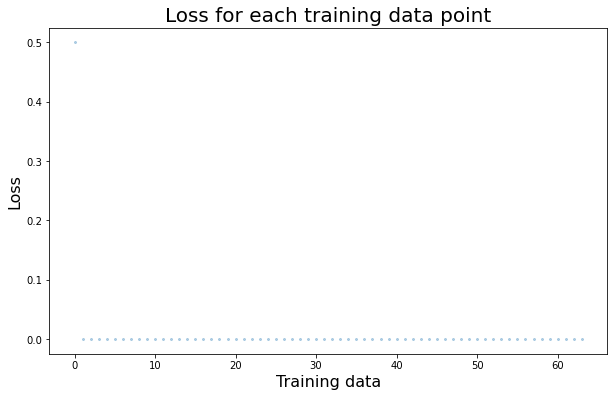

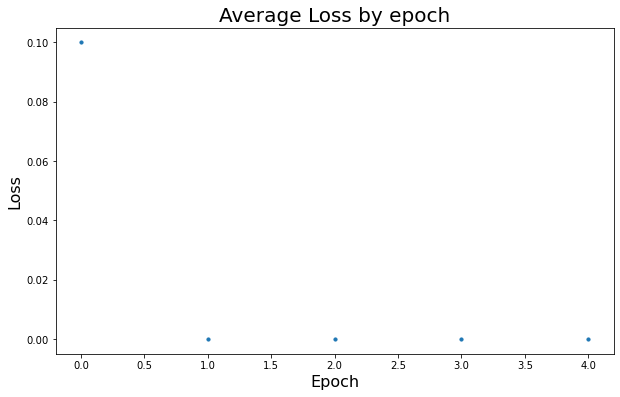

In [9]:
# Set up the number of perceptron per each layer:
p = 4 # Layer 1
q = 4 # Layer 2

# Set up the Learning rate
eta = 1/623

# 0: Random initialize the relevant data 
w1 = 2*np.random.rand(p, X_train.shape[1]) - 0.5 # Layer 1
b1 = np.random.rand(p)

w2 = 2*np.random.rand(q , p) - 0.5  # Layer 2
b2 = np.random.rand(q)

wOut = 2*np.random.rand(q) - 0.5  # Output Layer
bOut = np.random.rand(1)

mu = []
vec_y = []

# Start looping over dataset
for i in range(0, X_train.shape[0]):
    # 1: input the data 
    x = X_train[i]
    
    # 2: Start the algorithm
    # 2.1: Feed forward
    z1 = ReLU_act(np.dot(w1, x) + b1) # output layer 1 
    z2 = ReLU_act(np.dot(w2, z1) + b2) # output layer 2
    y = sigmoid_act(np.dot(wOut, z2) + bOut) # Output of the Output layer
    
    #2.2: Compute the output layer's error
    delta_Out =  (y - y_train[i]) * sigmoid_act(y, der=True)
    
    #2.3: Backpropagate
    delta_2 = delta_Out * wOut * ReLU_act(z2, der=True) # Second Layer Error
    delta_1 = np.dot(delta_2, w2) * ReLU_act(z1, der=True) # First Layer Error
    
    # 3: Gradient descent 
    wOut = wOut - eta*delta_Out*z2  # Outer Layer
    bOut = bOut - eta*delta_Out
    
    w2 = w2 - eta*np.kron(delta_2, z1).reshape(q,p) # Hidden Layer 2
    b2 = b2 - eta*delta_2
    
    w1 = w1 - eta*np.kron(delta_1, x).reshape(p, x.shape[0]) # Hidden Layer 1
    b1 = b1 - eta*delta_1
    
    # 4. Computation of the loss function
    mu.append((1/2)*(y - y_train[i])**2)
    vec_y.append(y[0])

    
# Plotting the Cost function for each training data     
plt.figure(figsize=(10,6))
plt.scatter(np.arange(0, X_train.shape[0]), mu, alpha=0.3, s=4, label='mu')
plt.title('Loss for each training data point', fontsize=20)
plt.xlabel('Training data', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

# Plotting the average cost function over 5 training data    
pino = []
for i in range(0, 5):
    pippo = 0
    for m in range(0, 5):
        pippo += vec_y[10*i+m]/10
    pino.append(pippo)
    
plt.figure(figsize=(10,6))
plt.scatter(np.arange(0, 5), pino, alpha=1, s=10, label='error')
plt.title('Average Loss by epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## Define the Training as a Function

Since we have learnt how to train an ANN, we are in the position of define a function that does that, by eating the X_train, Y_train as well as the number of perceptron $p,q$ for the first and second hidden layer, and the learning rate $\eta$.

In [10]:
def ANN_train(X_train, y_train, p=4, q=4, eta=0.0015):
    # 0: Random initialize the relevant data 
    w1 = 2*np.random.rand(p , X_train.shape[1]) - 0.5 # Layer 1
    b1 = np.random.rand(p)

    w2 = 2*np.random.rand(q , p) - 0.5  # Layer 2
    b2 = np.random.rand(q)

    wOut = 2*np.random.rand(q) - 0.5   # Output Layer
    bOut = np.random.rand(1)

    mu = []
    vec_y = []

    # Start looping over dataset
    for i in range(0, X_train.shape[0]-1): 
        # 1: input the data 
        x = X_train[i]
    
        # 2: Start the algorithm
        # 2.1: Feed forward
        z1 = ReLU_act(np.dot(w1, x) + b1) # output layer 1 
        z2 = ReLU_act(np.dot(w2, z1) + b2) # output layer 2
        y = sigmoid_act(np.dot(wOut, z2) + bOut) # Output of the Output layer
    
        #2.2: Compute the output layer's error
        delta_Out = 2 * (y-y_train[i]) * sigmoid_act(y, der=True)
    
        #2.3: Backpropagate
        delta_2 = delta_Out * wOut * ReLU_act(z2, der=True) # Second Layer Error
        delta_1 = np.dot(delta_2, w2) * ReLU_act(z1, der=True) # First Layer Error
    
        # 3: Gradient descent 
        wOut = wOut - eta*delta_Out*z2  # Outer Layer
        bOut = bOut - eta*delta_Out
    
        w2 = w2 - eta*np.kron(delta_2, z1).reshape(q,p) # Hidden Layer 2
        b2 = b2 -  eta*delta_2
    
        w1 = w1 - eta*np.kron(delta_1, x).reshape(p, x.shape[0])
        b1 = b1 - eta*delta_1
    
        # 4. Computation of the loss function
        mu.append((y-y_train[i])**2)
        vec_y.append(y)
    
    batch_loss = []
    for i in range(0, 5):
        loss_avg = 0
        for m in range(0, 5):
            loss_avg += vec_y[10*i+m]/10
        batch_loss.append(loss_avg)
    
    plt.figure(figsize=(10,6))
    plt.scatter(np.arange(1, len(batch_loss)+1), batch_loss, alpha=1, s=10, label='error')
    plt.title('Averege Loss by epoch', fontsize=20)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.show()
    
    return w1, b1, w2, b2, wOut, bOut, mu

<ipython-input-7-15575d3ca699>:6: RuntimeWarning: overflow encountered in exp
  f = 1/(1+ np.exp(- x))


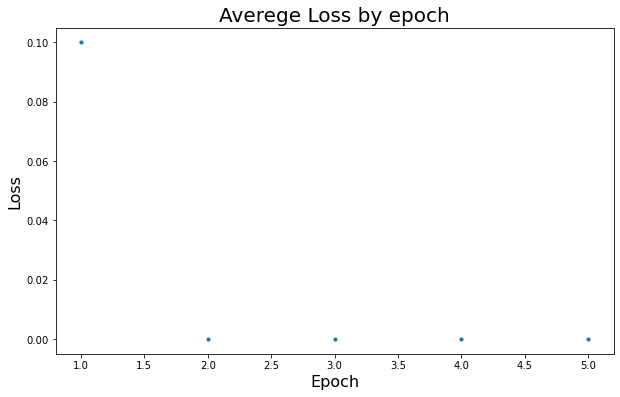

In [11]:
w1, b1, w2, b2, wOut, bOut, mu = ANN_train(X_train, y_train, p=8, q=4, eta=0.0015)

# Compute Predictions

We now have to compute predictions from our trained ANN. In order to do so we need to recall the trained parameters $\{w\}, \{b\}$ and use them to actually get the predictions. 

In [12]:
def ANN_pred(X_test, w1, b1, w2, b2, wOut, bOut, mu):
    pred = []
    
    for i in range(0, X_test.shape[0]): 
        # 1: input the data 
        x = X_test[i]
        
        # 2.1: Feed forward
        z1 = ReLU_act(np.dot(w1, x) + b1) # output layer 1 
        z2 = ReLU_act(np.dot(w2, z1) + b2) # output layer 2
        y = sigmoid_act(np.dot(wOut, z2) + bOut)  # Output of the Output layer
        
        # Append the prediction;
        # We now need a binary classifier; we this apply an Heaviside Theta and we set to 0.5 the threshold
        # if y < 0.5 the output is zero, otherwise is 1
        pred.append(np.heaviside(y - 0.5, 1)[0])
    
    return np.array(pred)

In [13]:
predictions = ANN_pred(X_test, w1, b1, w2, b2, wOut, bOut, mu)

<ipython-input-7-15575d3ca699>:6: RuntimeWarning: overflow encountered in exp
  f = 1/(1+ np.exp(- x))


# Evaluation report

In [14]:
dict_labels = {
    0: "Poor",
    1: "Good"
}

In [15]:
# # Plot the confusion matrix
# cm = confusion_matrix(y_test, predictions)

# df_cm = pd.DataFrame(cm, index = [dict_labels[i] for i in range(0,2)], columns = [dict_labels[i] for i in range(0,2)])
# plt.figure(figsize = (7,7))
# sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
# plt.xlabel("Predicted Class", fontsize=18)
# plt.ylabel("True Class", fontsize=18)
# plt.show()

In [16]:
# Plot the confusion matrix
# From https://stackoverflow.com/a/44193420

def pretty_print_conf_matrix(y_true, y_pred, 
                             classes,
                             normalize=False,
                             title='Confusion matrix',
                             cmap=plt.cm.Blues,
                             no=0):
    """
    Mostly stolen from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Normalization changed, classification_report stats added below plot
    """
    cm = confusion_matrix(y_true, y_pred)

    # Configure Confusion Matrix Plot Aesthetics (no text yet) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Place Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)


    # Add Precision, Recall, F-1 Score as Captions Below Plot
    rpt = classification_report(y_true, y_pred)
    rpt = rpt.replace('avg / total', '      avg')
    rpt = rpt.replace('support', 'N Obs')

    plt.annotate(rpt, 
                 xy = (0,0), 
                 xytext = (-50, -140), 
                 xycoords='axes fraction', textcoords='offset points',
                 fontsize=12, ha='left')    

    # Plot
    plt.tight_layout()
    
    # Save picture
    os.chdir(pictureDir)
    plt.savefig(str(no) + "_Confusion_Matrix.png")  
    os.chdir(currentDir)

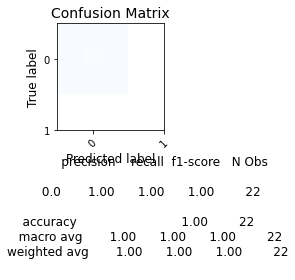

In [17]:
pretty_print_conf_matrix(y_test, predictions, 
                         classes= ['0', '1'],
                         normalize=True, 
                         title='Confusion Matrix', 
                         no=1)

Of course the outcome is **not** amazing, but we have to keep in mind that this is a very simple (almost naive) implementation of an artificial neural network whose main goal was to explain (mostly to myself) how an ANN works in practice and how it is possible to implement it into *Python* from scratch. 

# The ANN as a Class

We want now to implement the code as Class for Python, so that we could easiliy generalize it; the goal is to have a class from which we can instantiate an object "Neural Network", and add to it as many hidden layers with as many neurons we want, with the desired activation functions and so on. To generalize further, we define also the *Activation_function* class and the *layers* class, so we may easily add more activation funtions or more different layers (such as Convolutional or Pooling layers for Convolutional Neural Networks).

Within the ANN class, we define the following methods:
* **add**: it eats a tuple ( int(number_of_neurons), string(activation_function) ), i.e. the output of the ANN.layer method. It is a void method. It updates the HiddenLayer string defined by the __init__ method. 
* **FeedForward**: it implements the Feed Forward layer by layer.
* **BackPropagation**: it implements the whole gradient descent mechanism; first, it computes the errors by implementing the backpropagation; then, it updates the ANN parameters by gradient descent. 
* **Fit**: this method eats the training features and labels and fits the ANN by calling iteratively *FeedForward* and *BackPropagation* methods. This allow us to easily modify (or generalize) either *FeedForward* or *BackPropagation* methods without altering the *Fit* method.
* **predict**: it eats the featurs and spits the label predictions. 
* **set_learning_rate**: by default the learning rate is initialized to be 1, but we can call this method to set it to a different value. 
* **get_accuracy, get_avg_accuracy**: these methods' aim is to return the cost function either at each step of the training process or averaging over 5 rows, respectively.

In the **layers** class we have
* **layer**: it eats two imputs, the number of neurons and the activation function (as a string); it returns a tuple of the two. The idea is to leave room for a generalization of the *layers.layer* method later on by adding multiple layer type (i.e. Pooling or Convolutional layers for the CNN).

In the **Activation_function** class we have
* **ReLU_act, sigmoid_act**: these are the activation functions. They can be easily generalized (LeakyReLU, ParametricReLU, etc.)

## An initialization Improvement

I recently found an interesting article on the web [1] (see [2] for an easy&fast review) where the authors were able to define a well-performing initialization method for the $\{w\}$ and $\{b\}$ of the ANN. It relies on the knowledge of the dimension of the previous layer; so they are gaussian-distributed randomly initialized values divided by the squareroot of the dimension of the previous layer, i.e.
> w = np.random.randn(layer_size[l],layer_size[l-1])*np.sqrt(2/layer_size[l-1])
>
> b = np.random.randn(layer_size[l])*np.sqrt(2/layer_size[l-1])

Using that, as well as *Parametric Rectified Linear Units* (P-ReLU), they were able to obtain a result that
> [...] *is the first to surpass human-level performance (5.1%, Russakovsky et al.) on this visual recognition challenge.*

The visual recognition challenge they are referring to is the **ImageNet Large Scale Visual Recognition Competition (ILSVRC) 2014**.

-----
[1] https://arxiv.org/abs/1502.01852

[2] https://towardsdatascience.com/random-initialization-for-neural-networks-a-thing-of-the-past-bfcdd806bf9e

In [18]:
'''
Artificial Neural Network Class
'''
class ANN:    
    '''
    Initialize the ANN;
    HiddenLayer vector : will contain the Layers' info
    w, b, phi = (empty) arrays that will contain all the w, b and activation functions for all the Layers
    mu = cost function
    eta = a standard learning rate initialization. It can be modified by the 'set_learning_rate' method
    '''
    def __init__(self) :
        self.HiddenLayer = []
        self.w = []
        self.b = []
        self.phi = []
        self.mu = []
        self.eta = 1 #set up the proper Learning Rate!!
    
    '''
    add method: to add layers to the network
    '''
    def add(self, lay = (4, 'ReLU') ):
        self.HiddenLayer.append(lay)
    
    '''
    FeedForward method: as explained before. 
    '''
    @staticmethod
    def FeedForward(w, b, phi, x):
        return phi(np.dot(w, x) + b)
        
    '''
    BackPropagation algorithm implementing the Gradient Descent 
    '''
    def BackPropagation(self, x, z, Y, w, b, phi):
        self.delta = []
        
        # We initialize ausiliar w and b that are used only inside the backpropagation algorithm once called        
        self.W = []
        self.B = []
        
        # We start computing the LAST error, the one for the OutPut Layer 
        self.delta.append(  (z[len(z)-1] - Y) * phi[len(z)-1](z[len(z)-1], der=True) )
        
        '''Now we BACKpropagate'''
        # We thus compute from next-to-last to first
        for i in range(0, len(z)-1):
            self.delta.append( np.dot( self.delta[i], w[len(z)- 1 - i] ) * phi[len(z)- 2 - i](z[len(z)- 2 - i], der=True) )
        
        # We have the error array ordered from last to first; we flip it to order it from first to last
        self.delta = np.flip(self.delta, 0)  
        
        # Now we define the delta as the error divided by the number of training samples
        self.delta = self.delta/self.X.shape[0] 
        
        '''GRADIENT DESCENT'''
        # We start from the first layer that is special, since it is connected to the Input Layer
        self.W.append( w[0] - self.eta * np.kron(self.delta[0], x).reshape( len(z[0]), x.shape[0] ) )
        self.B.append( b[0] - self.eta * self.delta[0] )
        
        # We now descend for all the other Hidden Layers + OutPut Layer
        for i in range(1, len(z)):
            self.W.append( w[i] - self.eta * np.kron(self.delta[i], z[i-1]).reshape(len(z[i]), len(z[i-1])) )
            self.B.append( b[i] - self.eta * self.delta[i] )
        
        # We return the descended parameters w, b
        return np.array(self.W), np.array(self.B)
    
    
    '''
    Fit method: it calls FeedForward and Backpropagation methods
    '''
    def Fit(self, X_train, y_train):            
        print('Start fitting...')
        '''
        Input layer
        '''
        self.X = X_train
        self.Y = y_train
        
        '''
        We now initialize the Network by retrieving the Hidden Layers and concatenating them 
        '''
        print('Model recap: \n')
        print('You are fitting an ANN with the following amount of layers: ', len(self.HiddenLayer))
        
        for i in range(0, len(self.HiddenLayer)) :
            print('Layer ', i+1)
            print('Number of neurons: ', self.HiddenLayer[i][0])
            if i==0:
                # We now try to use the He et al. Initialization from ArXiv:1502.01852
                self.w.append( np.random.randn(self.HiddenLayer[i][0] , self.X.shape[1])/np.sqrt(2/self.X.shape[1]) )
                self.b.append( np.random.randn(self.HiddenLayer[i][0])/np.sqrt(2/self.X.shape[1]))
                # Old initialization
                #self.w.append(2 * np.random.rand(self.HiddenLayer[i][0] , self.X.shape[1]) - 0.5)
                #self.b.append(np.random.rand(self.HiddenLayer[i][0]))
                
                # Initialize the Activation function
                for act in Activation_function.list_act():
                    if self.HiddenLayer[i][1] == act :
                        self.phi.append(Activation_function.get_act(act))
                        print('\tActivation: ', act)

            else :
                # We now try to use the He et al. Initialization from ArXiv:1502.01852
                self.w.append( np.random.randn(self.HiddenLayer[i][0] , self.HiddenLayer[i-1][0] )/np.sqrt(2/self.HiddenLayer[i-1][0]))
                self.b.append( np.random.randn(self.HiddenLayer[i][0])/np.sqrt(2/self.HiddenLayer[i-1][0]))
                # Old initialization
                #self.w.append(2*np.random.rand(self.HiddenLayer[i][0] , self.HiddenLayer[i-1][0] ) - 0.5)
                #self.b.append(np.random.rand(self.HiddenLayer[i][0]))
                
                # Initialize the Activation function
                for act in Activation_function.list_act():
                    if self.HiddenLayer[i][1] == act :
                        self.phi.append(Activation_function.get_act(act))
                        print('\tActivation: ', act)
            
        '''
        Now we start the Loop over the training dataset
        '''  
        for j in range(0, self.X.shape[0]): # loop over the training set
            '''
            Now we start the feed forward
            '''  
            self.z = []
            
            self.z.append( self.FeedForward(self.w[0], self.b[0], self.phi[0], self.X[j]) ) # First layer
            
            for i in range(1, len(self.HiddenLayer)): #Looping over layers
                self.z.append( self.FeedForward(self.w[i] , self.b[i], self.phi[i], self.z[i-1] ) )
        
            
            '''
            Here we backpropagate
            '''      
            self.w, self.b  = self.BackPropagation(self.X[i], self.z, self.Y[i], self.w, self.b, self.phi)
            
            '''
            Compute cost function
            ''' 
            self.mu.append(
                (1/2) * np.dot(self.z[len(self.z)-1] - self.Y[i], self.z[len(self.z)-1] - self.Y[j]) 
            )
            
        print('Fit done. \n')

    '''
    predict method
    '''
    def predict(self, X_test):
        print('Starting predictions...')
        
        self.pred = []
        self.XX = X_test
        
        for j in range(0, self.XX.shape[0]): # loop over the training set
            '''
            Now we start the feed forward
            '''  
            self.z = []
            
            self.z.append(self.FeedForward(self.w[0] , self.b[0], self.phi[0], self.XX[j])) #First layer
    
            for i in range(1, len(self.HiddenLayer)) : # loop over the layers
                self.z.append( self.FeedForward(self.w[i] , self.b[i], self.phi[i], self.z[i-1]))
       
            # Append the prediction;
            # We now need a binary classifier; we this apply an Heaviside Theta and we set to 0.5 the threshold
            # if y < 0.5 the output is zero, otherwise is zero
            self.pred.append( np.heaviside(self.z[-1] - 0.5, 1)[0] ) # NB: self.z[-1] is the last element of the self.z list
        
        print('Predictions done. \n')

        return np.array(self.pred)
   
    '''
    We need a method to retrieve the accuracy for each training data to follow the learning of the ANN
    '''
    def get_accuracy(self):
        return np.array(self.mu)
    
    # This is the averaged version
    def get_avg_accuracy(self):
        import math
        self.batch_loss = []
        for i in range(0, 10):
            self.loss_avg = 0
            # To set the batch in 10 element/batch we use math.ceil method
            # int(math.ceil((self.X.shape[0]-10) / 10.0))    - 1
            for m in range(0, (int(math.ceil((self.X.shape[0]-10) / 10.0))   )-1):
                #self.loss_avg += self.mu[60*i+m]/60
                self.loss_avg += self.mu[(int(math.ceil((self.X.shape[0]-10) / 10.0)) )*i + m]/(int(math.ceil((self.X.shape[0]-10) / 10.0)) )
            self.batch_loss.append(self.loss_avg)
        return np.array(self.batch_loss)
    
    '''
    Method to set the learning rate
    '''
    def set_learning_rate(self, et=1):
        self.eta = et
        
'''
layers class
'''
class layers :
    '''
    Layer method: used to call standar layers to add. 
    Easily generalizable to more general layers (Pooling and Convolutional layers)
    '''        
    def layer(p=4, activation='ReLU'):
        return (p, activation)

'''
Activation functions class
'''
class Activation_function(ANN):
    def __init__(self) :
        super().__init__()
        
    '''
    Define the sigmoid activator; we ask if we want the sigmoid or its derivative
    '''
    def sigmoid_act(x, der=False):
        if der : #derivative of the sigmoid
            f = 1/(1+ np.exp(-x))*(1-1/(1+ np.exp(-x)))
        else : # sigmoid
            f = 1/(1+ np.exp(-x))
        return f

    '''
    Define the Rectifier Linear Unit (ReLU)
    '''
    def ReLU_act(x, der=False):
        if der: # the derivative of the ReLU is the Heaviside Theta
            f = np.heaviside(x, 1)
        else :
            f = np.maximum(x, 0)
        return f
    
    def list_act():
        return ['sigmoid', 'ReLU']
    
    def get_act(string='ReLU'):
        if string == 'ReLU':
            return ReLU_act
        elif string == 'sigmoid':
            return sigmoid_act
        else:
            return sigmoid_act

### Instantiating the class and Fitting the model

Now we instantiate our model, that will be exactly the same as before, i.e. a two-hidden layer with 8 and 4 neurons respectively and with ReLU activation plus an OutPut layer with a single neuron with sigmoid activation. 

We will set the learning rate and then fit the model; after that we recover the accuracy history (even in the averaged over 10 batches) and finally we compute the predictions.

In [19]:
model = ANN()

model.add(layers.layer(8, 'ReLU'))
model.add(layers.layer(4, 'ReLU'))
model.add(layers.layer(1, 'sigmoid'))

model.set_learning_rate(0.8)

model.Fit(X_train, y_train)
acc_val = model.get_accuracy()
acc_avg_val = model.get_avg_accuracy()

predictions = model.predict(X_test)

Start fitting...
Model recap: 

You are fitting an ANN with the following amount of layers:  3
Layer  1
Number of neurons:  8
	Activation:  ReLU
Layer  2
Number of neurons:  4
	Activation:  ReLU
Layer  3
Number of neurons:  1
	Activation:  sigmoid
Fit done. 

Starting predictions...
Predictions done. 



/Users/kellie/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<ipython-input-18-e1165e1fb375>:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self.W), np.array(self.B)
<ipython-input-7-15575d3ca699>:6: RuntimeWarning: overflow encountered in exp
  f = 1/(1+ np.exp(- x))


We plot the accuracy scores we have retrieved:

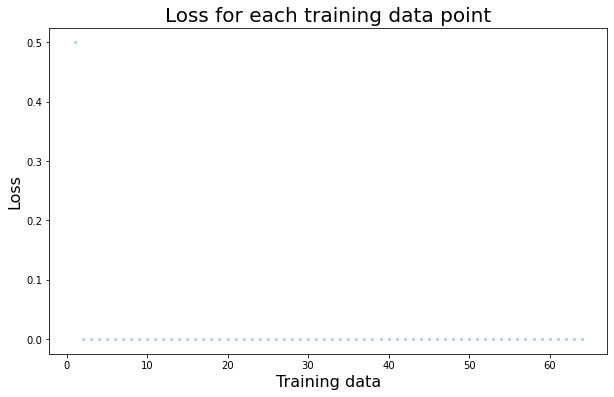

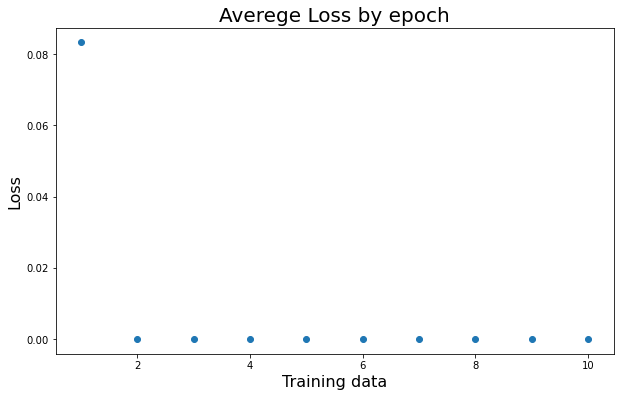

In [20]:
plt.figure(figsize=(10,6))
plt.scatter(np.arange(1, X_train.shape[0]+1), acc_val, alpha=0.3, s=4, label='mu')
plt.title('Loss for each training data point', fontsize=20)
plt.xlabel('Training data', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(np.arange(1, len(acc_avg_val)+1), acc_avg_val, label='mu')
plt.title('Averege Loss by epoch', fontsize=20)
plt.xlabel('Training data', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

And finally see how the system behaves as a classifier:

In [21]:
# # Plot the confusion matrix
# cm = confusion_matrix(y_test, predictions)

# df_cm = pd.DataFrame(cm, index = [dict_labels[i] for i in range(0,2)], columns = [dict_labels[i] for i in range(0,2)])
# plt.figure(figsize = (7,7))
# sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
# plt.xlabel("Predicted Class", fontsize=18)
# plt.ylabel("True Class", fontsize=18)
# plt.show()

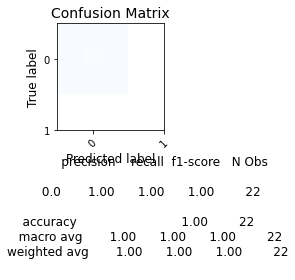

In [22]:
pretty_print_conf_matrix(y_test, predictions, 
                         classes= ['0', '1'],
                         normalize=True, 
                         title='Confusion Matrix',
                         no=2)

## Conclusions
Notice that, having changed the random initialization following the He et al. procedure, we have improved the classification slightly (recall that this still is a very naive model). Now we can easily add more layers and, in the spirit of Convolutional Neural Network, we can easily modify the class to add for more generic layers like *Convolutional* or *Pooling* layers.

We can now try a more *deep* neural network for the case at hand:

Start fitting...
Model recap: 

You are fitting an ANN with the following amount of layers:  4
Layer  1
Number of neurons:  24
	Activation:  ReLU
Layer  2
Number of neurons:  12
	Activation:  sigmoid
Layer  3
Number of neurons:  6
	Activation:  ReLU
Layer  4
Number of neurons:  1
	Activation:  sigmoid
Fit done. 



<ipython-input-7-15575d3ca699>:6: RuntimeWarning: overflow encountered in exp
  f = 1/(1+ np.exp(- x))
<ipython-input-18-e1165e1fb375>:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self.W), np.array(self.B)


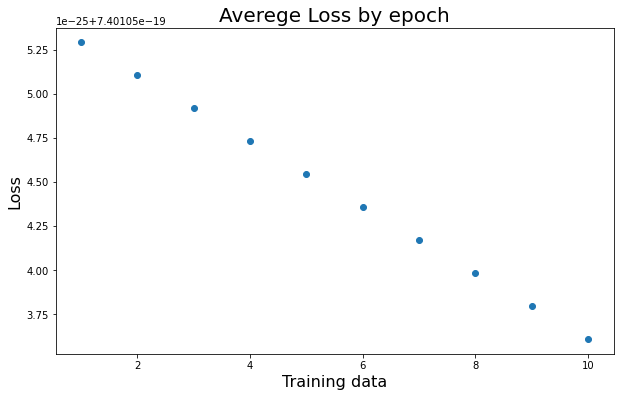

Starting predictions...
Predictions done. 



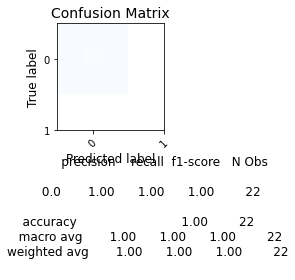

In [23]:
model = ANN()

model.add(layers.layer(24, 'ReLU'))
model.add(layers.layer(12, 'sigmoid'))
model.add(layers.layer(6, 'ReLU'))
model.add(layers.layer(1, 'sigmoid'))

model.set_learning_rate(0.8)

model.Fit(X_train, y_train)
acc_val = model.get_accuracy()
acc_avg_val = model.get_avg_accuracy()

plt.figure(figsize=(10,6))
plt.scatter(np.arange(1, len(acc_avg_val)+1), acc_avg_val, label='mu')
plt.title('Averege Loss by epoch', fontsize=20)
plt.xlabel('Training data', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

predictions = model.predict(X_test)

# Plot the confusion matrix
pretty_print_conf_matrix(y_test, predictions, 
                         classes= ['0', '1'],
                         normalize=True, 
                         title='Confusion Matrix',
                         no=3)